### VCM Research

### Difference-in-Differences (Demand)


In [47]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas 
from tensorflow import keras


### Equation 1

In [124]:
file_path = 'C:\\Users\\grandonb\\Desktop\\VCM\\VCM\\VCM_Demand.csv'

# open the file and store the data in a data frame
df = pd.read_csv(file_path, low_memory=False)

# melt years columns
columns_to_melt = [str(i) for i in range(2004, 2023)]

# Melt the selected columns, using the column names as the id_vars
df = pd.melt(df, id_vars=['Project ID', 'Registry', 'Voluntary_Status', 'Scope', 'Type', 'Country', 'Total_Credits'], 
             value_vars=columns_to_melt, var_name='years', value_name='demand').dropna()

# Convert years to numeric
df['years'] = pd.to_numeric(df['years'])

# Convert surplus to numeric
df['demand'] = pd.to_numeric(df['demand'])

df

,Project ID,Registry,Voluntary_Status,Scope,Type,Country,Total_Credits,years,demand
0,ACR102,ACR,Completed,Chemical_Processes,Reduction,United States of America,17666,2004,0
1,ACR103,ACR,Completed,Agriculture,Reduction,United States of America,44202,2004,0
2,ACR106,ACR,Completed,Waste_Management,Reduction,United States of America,109452,2004,0
3,ACR107,ACR,Completed,Industrial_Commercial,Reduction,Bolivia,1138,2004,0
4,ACR109,ACR,Completed,Industrial_Commercial,Reduction,United States of America,200000,2004,0
...,...,...,...,...,...,...,...,...,...
56976,VCS995,VCS,Registered,Forestry_Land_Use,Removal,Uganda,144643,2022,5618
56977,VCS996,VCS,Registered,Forestry_Land_Use,Removal,Kenya,257623,2022,82000
56978,VCS998,VCS,Registered,Household_Community,Reduction,Vietnam,29018,2022,0
56979,VCSOPR10,VCS,Transfer to another GHG program,Forestry_Land_Use,Mixed,United States of America,78497,2022,0


In [125]:
grouped = df.groupby('Country')
summary = grouped['Project ID'].nunique().reset_index(name='N')
summary = pd.merge(summary, grouped['demand'].describe()[['mean', 'std', 'min', 'max']].round(), on='Country')

df_summary = pd.DataFrame(summary)

df_summary

,Country,N,mean,std,min,max
0,Argentina,7,5201.0,19651.0,0.0,173090.0
1,Aruba,1,51193.0,81455.0,0.0,229077.0
2,Australia,5,9289.0,18187.0,0.0,85504.0
3,Bangladesh,40,4046.0,62778.0,0.0,1245935.0
4,Belize,3,20350.0,53845.0,0.0,235632.0
...,...,...,...,...,...,...
94,United States of America,693,12932.0,104067.0,0.0,6390607.0
95,Uruguay,9,35727.0,162196.0,0.0,1310380.0
96,Vietnam,24,8872.0,50503.0,0.0,736775.0
97,Zambia,12,26122.0,189912.0,0.0,2261722.0


In [126]:
# Specify the treatment group

treatment_group = ['Switzerland', 'Belize', 'Spain', 'Costa Rica', 'Paraguay', 
                   'New Zealand', 'Germany', 'United Kingdom', 'Colombia', 'Fiji']

# Create treatment and post_treatment columns
df['treatment'] = df['Country'].isin(treatment_group).astype(int)
df['post_treatment'] = (df['years'] >= 2018).astype(int)

# Fit the model using the ols function
model = smf.ols(formula = 'demand ~ treatment + post_treatment + treatment*post_treatment', data = df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     240.1
Date:                Mon, 20 Feb 2023   Prob (F-statistic):          8.19e-155
Time:                        12:46:04   Log-Likelihood:            -7.4856e+05
No. Observations:               56981   AIC:                         1.497e+06
Df Residuals:                   56977   BIC:                         1.497e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

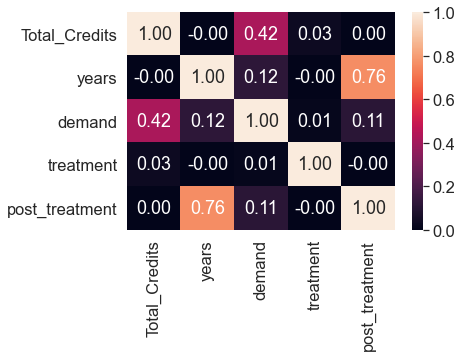

In [128]:
#print corr_matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.show()

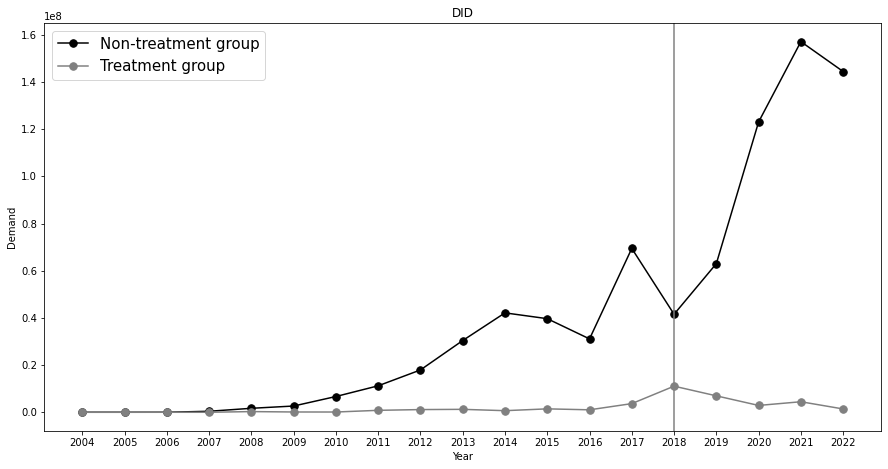

In [17]:
# Create a pivot table to summarize the surplus by year and treatment
ax = df.pivot_table(values='demand', index='years', columns='treatment', aggfunc='sum').plot(
    figsize=(15, 7.5),
    marker='.', 
    markersize=15, 
    title='DID',
    xlabel='Year',
    ylabel='Demand',
    # Set the x-axis ticks to match the years in the dataframe
    xticks=df['years'].drop_duplicates().sort_values().astype('int'),
    color=['black', 'gray']
)

# Add a vertical line to show the year of the policy change
ax.axvline(x=2018, color='gray', linestyle='-')
ax.legend(['Non-treatment group', 'Treatment group'], fontsize=15)

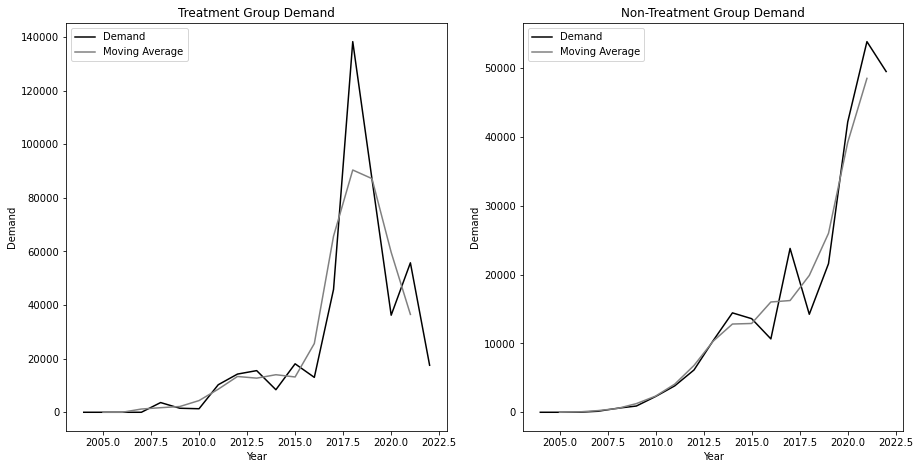

In [56]:
# Group the treatment data by year
grouped_treatment = df[df['Country'].isin(treatment_group)].groupby('years')

# Group the non-treatment data by year
grouped_non_treatment = df[~df['Country'].isin(treatment_group)].groupby('years')

# Compute the rolling average for treatment group
rolling_avg_treatment = grouped_treatment['demand'].mean().rolling(window=3, center=True).mean()

# Compute the rolling average for non-treatment group
rolling_avg_non_treatment = grouped_non_treatment['demand'].mean().rolling(window=3, center=True).mean()

plt.figure(figsize=(15, 7.5))

# Plot the demand and the rolling average for treatment group
plt.subplot(1, 2, 1)
plt.plot(grouped_treatment['years'].first(), grouped_treatment['demand'].mean(), label='Demand', color = "black")
plt.plot(rolling_avg_treatment.index, rolling_avg_treatment.values, label='Moving Average', color = "gray")
plt.title('Treatment Group Demand')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.legend()

# Plot the demand and the rolling average for non-treatment group
plt.subplot(1, 2, 2)
plt.plot(grouped_non_treatment['years'].first(), grouped_non_treatment['demand'].mean(), label='Demand', color = "black")
plt.plot(rolling_avg_non_treatment.index, rolling_avg_non_treatment.values, label='Moving Average', color = "gray")
plt.title('Non-Treatment Group Demand')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.legend()

plt.show()


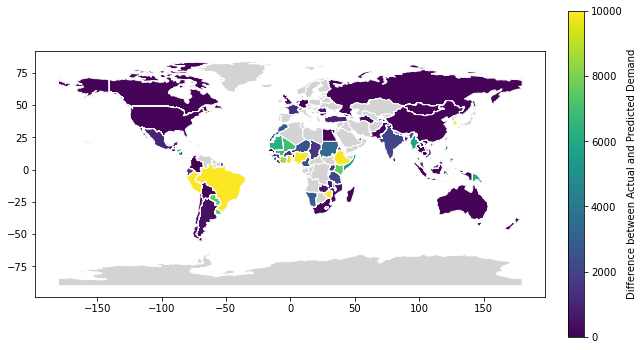

In [20]:
# Predict the surplus using the model
df['predicted_demand'] = model.predict()

# Calculate the difference between actual and predicted surplus
df['difference'] = df['demand'] - df['predicted_demand']

# Load the GeoDataFrame with country borders
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Create a GeoDataFrame for the missing countries
missing_countries = world[~world['name'].isin(df['Country'])].copy()
missing_countries.loc[:, 'difference'] = None

# Merge the GeoDataFrame with the results of the model
result = world.merge(df, left_on='name', right_on='Country', how='outer')
result = pd.concat([result, missing_countries], ignore_index=True, sort=False)

# Plot the choropleth map
ax = result.plot(column='difference', cmap='viridis', figsize=(10, 6), edgecolor='white', missing_kwds={'color': 'lightgray'})

# Add a color bar
cbar = plt.colorbar(ax.collections[0], ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Difference between Actual and Predicted Demand')

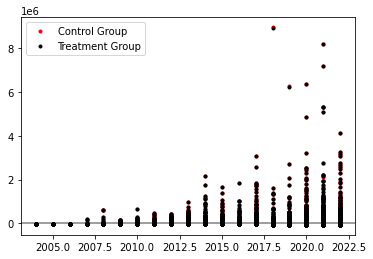

In [57]:
import statsmodels.formula.api as smf

# Fit a model without the treatment effect
control_model = smf.ols(formula = 'demand ~ post_treatment', data = df).fit()

# Fit the full model including the treatment effect
treatment_model = smf.ols(formula = 'demand ~ treatment + post_treatment + treatment*post_treatment', data = df).fit()

# Calculate the residuals for both models
df['residual_control'] = control_model.resid
df['residual_treatment'] = treatment_model.resid

# Plot the residuals against the time variable to visualize the parallel trend assumption
import matplotlib.pyplot as plt

plt.plot(round(df['years'],0), df['residual_control'], '.', label='Control Group', color = 'red')
plt.plot(round(df['years'],0), df['residual_treatment'], '.', label='Treatment Group', color = 'black')

plt.axhline(y=0, linestyle='-', color='black', alpha=0.5)
plt.legend()
plt.show()


### Placebo test (Demand)

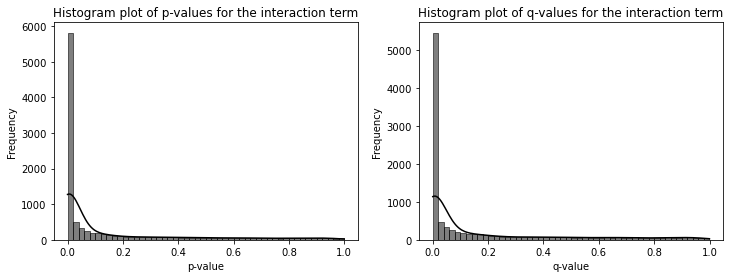

In [102]:
p_values = []

for i in range(10000):
    # set the seed for the random process
    random.seed(i)
    
    # create a list of countries that are not in the treatment group
    countries = list(set(countries for countries in df["Country"] if countries not in treatment_group))

    # select a random sample of countries from the list of non-treatment countries 
    # that has the same number of elements as the treatment group
    placebo_group = random.sample(countries, len(treatment_group))

    # create a new column in the dataframe indicating whether each country is in the placebo group
    df['placebo_treatment'] = df['Country'].isin(placebo_group).astype(int)

    # create a new column indicating whether the observation is post-treatment
    df['post_placebo_treatment'] = (df['years'] >= 2018).astype(int)

    model = smf.ols(formula = 'demand ~ placebo_treatment + post_placebo_treatment + placebo_treatment*post_placebo_treatment', data = df).fit()

    p_values.append(model.pvalues[3])


rejected, q_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
   
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(p_values, bins = 50, kde = True, color = 'black', ax=ax[0])
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("p-value")
ax[0].set_title("Histogram plot of p-values for the interaction term")

sns.histplot(q_values, bins = 50, kde = True, color = 'black', ax=ax[1])
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("q-value")
ax[1].set_title("Histogram plot of q-values for the interaction term")

plt.show()

### Placebo test (Surplus)

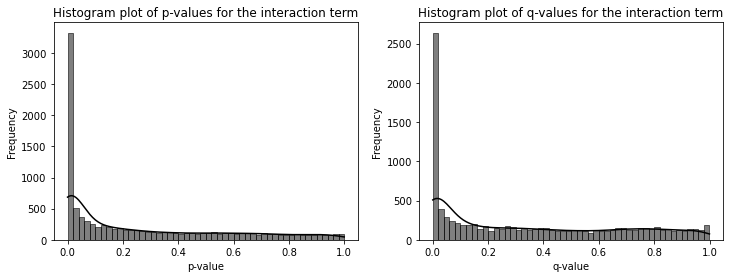

In [95]:
file_path = 'C:\\Users\\grandonb\\Desktop\\VCM\\VCM_IS-R.csv'

# open the file and store the data in a data frame
df = pd.read_csv(file_path, low_memory=False)

# melt years columns
columns_to_melt = [str(i) for i in range(2004, 2022)]

# Melt the selected columns, using the column names as the id_vars
df = pd.melt(df, id_vars=['Project ID', 'Registry', 'Voluntary Status', 'Scope', 'Type', 'Country', 'Total_Credits'], 
             value_vars=columns_to_melt, var_name='years', value_name='surplus').dropna()

# Convert years to numeric
df['years'] = pd.to_numeric(df['years'])

# Convert surplus to numeric
df['surplus'] = pd.to_numeric(df['surplus'])

# Specify the treatment group

treatment_group = ['Switzerland', 'Belize', 'Spain', 'Costa Rica', 'Paraguay', 
                   'New Zealand', 'Germany', 'United Kingdom', 'Colombia', 'Fiji']

p_values2 = []

for i in range(10000):
    # set the seed for the random process
    random.seed(i)
    
    # create a list of countries that are not in the treatment group
    countries = list(set(countries for countries in df["Country"] if countries not in treatment_group))

    # select a random sample of countries from the list of non-treatment countries 
    # that has the same number of elements as the treatment group
    placebo_group = random.sample(countries, len(treatment_group))

    # create a new column in the dataframe indicating whether each country is in the placebo group
    df['placebo_treatment'] = df['Country'].isin(placebo_group).astype(int)

    # create a new column indicating whether the observation is post-treatment
    df['post_placebo_treatment'] = (df['years'] >= 2018).astype(int)

    model = smf.ols(formula = 'surplus ~ placebo_treatment + post_placebo_treatment + placebo_treatment*post_placebo_treatment', data = df).fit()

    p_values2.append(model.pvalues[3])


rejected, q_values, _, _ = multipletests(p_values2, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
   
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(p_values2, bins = 50, kde = True, color = 'black', ax=ax[0])
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("p-value")
ax[0].set_title("Histogram plot of p-values for the interaction term")

sns.histplot(q_values, bins = 50, kde = True, color = 'black', ax=ax[1])
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("q-value")
ax[1].set_title("Histogram plot of q-values for the interaction term")

plt.show()

### Equation 2

In [111]:
file_path = 'C:\\Users\\grandonb\\Desktop\\VCM\\VCM\\VCM_Demand.csv'

# open the file and store the data in a data frame
df = pd.read_csv(file_path, low_memory=False)

# melt years columns
columns_to_melt = [str(i) for i in range(2004, 2022)]

# Melt the selected columns, using the column names as the id_vars
df = pd.melt(df, id_vars=['Project ID', 'Registry', 'Voluntary_Status', 'Scope', 'Type', 'Country', 'Total_Credits'], 
             value_vars=columns_to_melt, var_name='years', value_name='demand').dropna()

# Convert years to numeric
df['years'] = pd.to_numeric(df['years'])

# Convert surplus to numeric
df['demand'] = pd.to_numeric(df['demand'])

# Specify the treatment group
treatment_group = ['Switzerland', 'Belize', 'Spain', 'Costa Rica', 'Paraguay','New Zealand', 'Germany', 'United Kingdom', 'Colombia', 'Fiji']

# Create treatment and post_treatment columns
df['treatment'] = df['Country'].isin(treatment_group).astype(int)
df['post_treatment'] = (df['years'] >= 2018).astype(int)

df = pd.get_dummies(df, columns=['Type'], prefix='Type')

project_types = ['Agriculture', 'Carbon_Capture_Storage', 'Chemical_Processes', 'Forestry_Land_Use','Household_Community', 'Industrial_Commercial', 'Renewable_Energy', 'Transportation','Waste_Management']

df_dummies = pd.get_dummies(df['Scope'], columns=project_types)

df = pd.concat([df, df_dummies], axis=1)

project_types = ['Type_Reduction', 'Type_Removal', 'Type_Mixed']
dummy_cols = ['Agriculture', 'Carbon_Capture_Storage', 'Chemical_Processes', 'Forestry_Land_Use','Household_Community', 'Industrial_Commercial', 'Renewable_Energy', 'Transportation', 'Waste_Management']

# Divide Total_Credits into categories
df['credit_size'] = pd.cut(df['Total_Credits'], 
                           bins=[0, 10000, 100000, 10000000, np.inf], 
                           labels=['less_than_10000', '10000_to_100000', '1000000_to_10000000', 'exceeding_10000000'])


df = pd.get_dummies(df, columns=['credit_size'], prefix='credit_size')

df = pd.get_dummies(df, columns=['Registry'], prefix='Registry')

# Get the names of the new dummy columns created
credit_size_dummies = [col for col in df.columns if 'credit_size' in col]

results = []

for project_type in project_types:
    for dummy_col in dummy_cols:
        for credit_size in credit_size_dummies:
            for registry in ['Registry_ACR', 'Registry_CAR', 'Registry_GOLD', 'Registry_VCS']:
                formula = f'demand ~ treatment + post_treatment + treatment*post_treatment + {project_type} + {dummy_col} + {credit_size} + {registry}'
                model = smf.ols(formula=formula, data=df).fit()
                results.append(model)


### Results

In [113]:
results = []
columns = ['Project Type', 'Scope', 'Credit Size', 'Registry', 'Standard Error', 'P-Value']
results_df = pd.DataFrame(columns=columns)

for project_type in project_types:
    for dummy_col in dummy_cols:
        for credit_size in credit_size_dummies:
            for registry in ['Registry_ACR', 'Registry_CAR', 'Registry_GOLD', 'Registry_VCS']:
                formula = f'demand ~ treatment + post_treatment + treatment*post_treatment + {project_type} + {dummy_col} + {credit_size} + {registry}'
                model = smf.ols(formula=formula, data=df).fit()
                results.append({'Project Type': project_type, 'Scope': dummy_col, 'Credit Size': credit_size, 'Registry': registry, 
                                'Standard Error': round(model.bse[-1], 2), 'P-Value': round(model.pvalues[-1], 2)})

results_df = results_df.append(results, ignore_index=True)

results_df

,Project Type,Scope,Credit Size,Registry,Standard Error,P-Value
0,Type_Reduction,Agriculture,credit_size_less_than_10000,Registry_ACR,2303.13,0.01
1,Type_Reduction,Agriculture,credit_size_less_than_10000,Registry_CAR,1476.33,0.06
2,Type_Reduction,Agriculture,credit_size_less_than_10000,Registry_GOLD,1126.60,0.00
3,Type_Reduction,Agriculture,credit_size_less_than_10000,Registry_VCS,1029.38,0.00
4,Type_Reduction,Agriculture,credit_size_10000_to_100000,Registry_ACR,2283.93,0.00
...,...,...,...,...,...,...
427,Type_Mixed,Waste_Management,credit_size_1000000_to_10000000,Registry_VCS,1021.73,0.00
428,Type_Mixed,Waste_Management,credit_size_exceeding_10000000,Registry_ACR,2213.60,0.00
429,Type_Mixed,Waste_Management,credit_size_exceeding_10000000,Registry_CAR,1361.62,0.01
430,Type_Mixed,Waste_Management,credit_size_exceeding_10000000,Registry_GOLD,1074.30,0.00


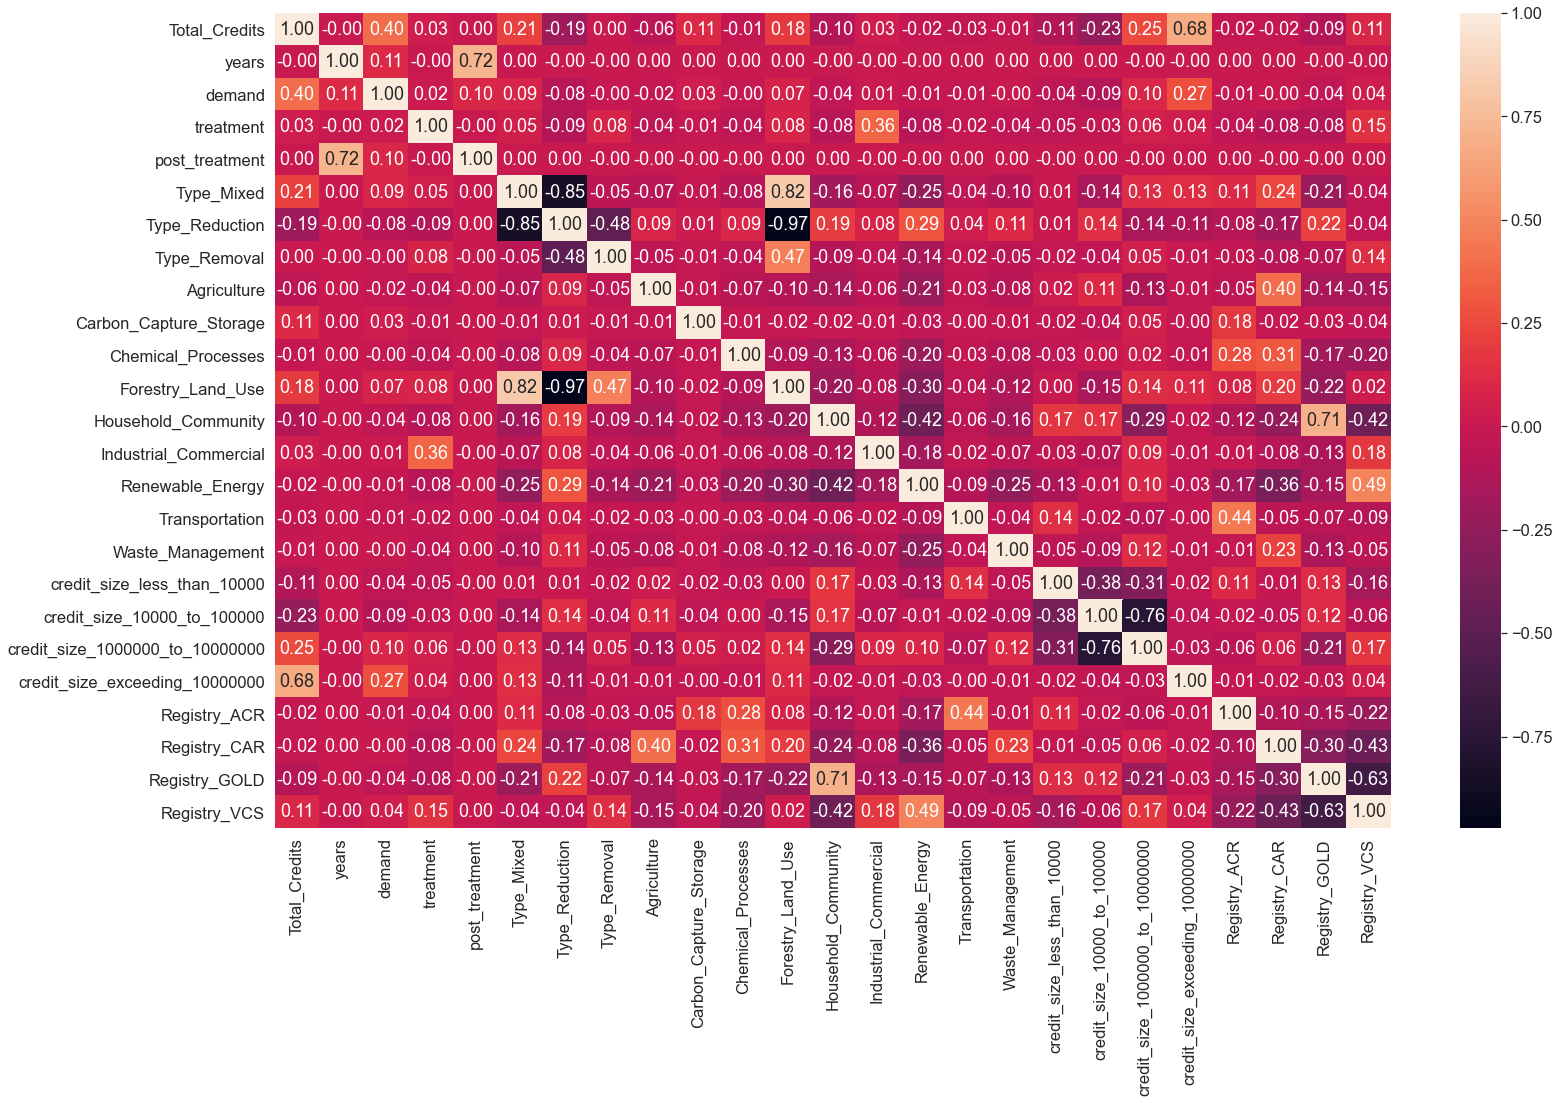

In [123]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(corr_matrix, annot=True, ax=ax, fmt='.2f')
plt.show()


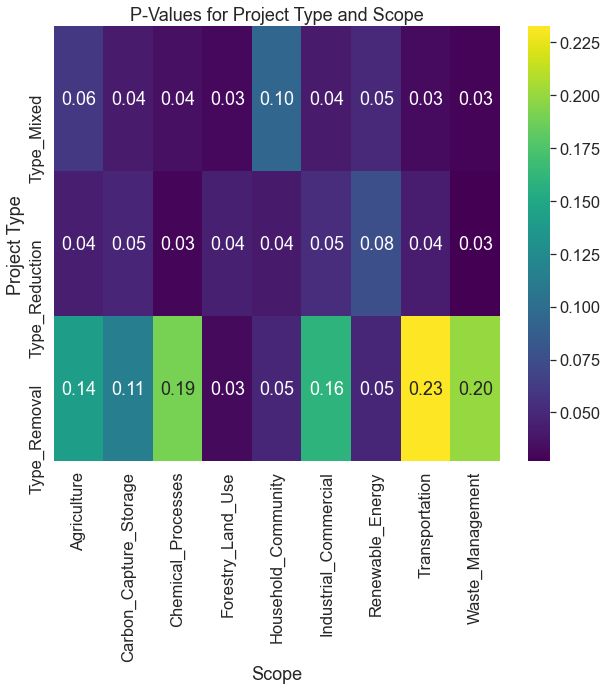

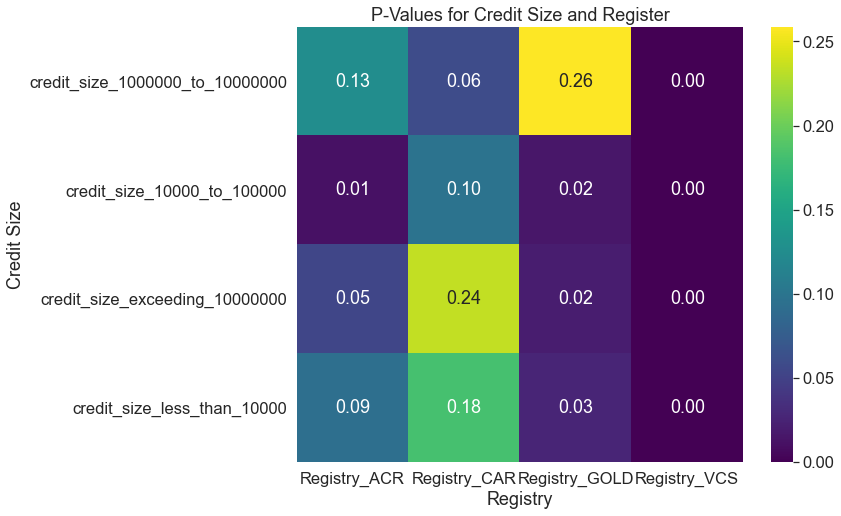

In [121]:
# First plot
pvalues_df_agg = pvalues_df.groupby(['Project Type', 'Scope'], as_index=False)['P-Value'].mean()
pvalues_pivot = pvalues_df_agg.pivot(index='Project Type', columns='Scope', values='P-Value')

plt.figure(figsize=(10, 8))
sns.heatmap(pvalues_pivot, cmap='viridis', annot=True, fmt='.2f')
plt.title('P-Values for Project Type and Scope')
plt.show()

# Second plot
pvalues_df_agg = pvalues_df.groupby(['Credit Size', 'Registry'], as_index=False)['P-Value'].mean()
pvalues_pivot = pvalues_df_agg.pivot(index='Credit Size', columns='Registry', values='P-Value')

plt.figure(figsize=(10, 8))
sns.heatmap(pvalues_pivot, cmap='viridis', annot=True, fmt='.2f')
plt.title('P-Values for Credit Size and Register')
plt.show()


### Alternative Approach

In [16]:
file_path = 'C:\\Users\\grandonb\\Desktop\\VCM\\VCM_Demand.csv'

# open the file and store the data in a data frame
df = pd.read_csv(file_path, low_memory=False)

# melt years columns
columns_to_melt = [str(i) for i in range(2004, 2022)]

# Melt the selected columns, using the column names as the id_vars
df = pd.melt(df, id_vars=['Project ID', 'Registry', 'Voluntary_Status', 'Scope', 'Type', 'Country', 'Total_Credits'], 
             value_vars=columns_to_melt, var_name='years', value_name='demand').dropna()

# Convert years to numeric
df['years'] = pd.to_numeric(df['years'])

# Convert surplus to numeric
df['demand'] = pd.to_numeric(df['demand'])

# Specify the treatment group
treatment_group = ['Switzerland', 'Belize', 'Spain', 'Costa Rica', 'Paraguay', 
                   'New Zealand', 'Germany', 'United Kingdom', 'Colombia', 'Fiji']

# Create treatment and post_treatment columns
df['treatment'] = df['Country'].isin(treatment_group).astype(int)
df['post_treatment'] = (df['years'] >= 2018).astype(int)

# Divide Total_Credits into categories
df['credit_size'] = pd.cut(df['Total_Credits'], 
                           bins=[0, 10000, 100000, 10000000, np.inf], 
                           labels=['less than 10,000', '10,000 to 100,000', '1,000,000 to 10,000,000', 'exceeding 10,000,000'])

# Fit separate regression models for each category of Total_Credits
for size in df['credit_size'].unique():
    credit_size_df = df[df['credit_size'] == size]
    model = smf.ols(formula = 'demand ~ treatment + post_treatment + treatment*post_treatment', data = credit_size_df).fit()
    print(f"Model for credit size: {size}")
    print(model.summary())

Model for credit size: 10,000 to 100,000
                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     184.5
Date:                Wed, 15 Feb 2023   Prob (F-statistic):          2.26e-118
Time:                        10:10:09   Log-Likelihood:            -2.6597e+05
No. Observations:               25776   AIC:                         5.319e+05
Df Residuals:                   25772   BIC:                         5.320e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [17]:
df = pd.get_dummies(df, columns=['Type'], prefix='Type')

project_types = ['Agriculture', 'Carbon_Capture_Storage', 'Chemical_Processes', 'Forestry_Land_Use',
                 'Household_Community', 'Industrial_Commercial', 'Renewable_Energy', 'Transportation',
                 'Waste_Management']

df_dummies = pd.get_dummies(df['Scope'], columns=project_types)

df = pd.concat([df, df_dummies], axis=1)

project_types = ['Type_Reduction', 'Type_Removal', 'Type_Mixed']
dummy_cols = ['Agriculture', 'Carbon_Capture_Storage', 'Chemical_Processes', 'Forestry_Land_Use','Household_Community', 'Industrial_Commercial', 'Renewable_Energy', 'Transportation', 'Waste_Management']

results = []

for project_type in project_types:
    for dummy_col in dummy_cols:
        formula = f'demand ~ treatment + post_treatment + treatment*post_treatment + {project_type} + {dummy_col}'
        model = smf.ols(formula=formula, data=df).fit()
        results.append(model)

# You can access the summary of each regression by using:
for result in results:
    print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     182.0
Date:                Wed, 15 Feb 2023   Prob (F-statistic):          8.83e-193
Time:                        10:10:14   Log-Likelihood:            -7.0582e+05
No. Observations:               53982   AIC:                         1.412e+06
Df Residuals:                   53976   BIC:                         1.412e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     206.9
Date:                Wed, 15 Feb 2023   Prob (F-statistic):          2.70e-219
Time:                        10:10:15   Log-Likelihood:            -7.0576e+05
No. Observations:               53982   AIC:                         1.412e+06
Df Residuals:                   53976   BIC:                         1.412e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               